In [166]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
import copy

from scipy.spatial.distance import cdist

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings('ignore')

from utils import *

from sklearn.metrics import f1_score

In [4]:
## read data as a dictionary with each subject as a different key
## the sessions are included as a column in each dataframe
pathData = Path(r'./TrainingData')
dctData = read_data(pathData)

In [3]:
## upsample labels using nearest neighbor
dctUps = upsampleData(dctData)

In [5]:
## count number of timesteps for each session of each subject
dctClass = {f'subject_{k+1}':pd.DataFrame(index = range(1, 9), columns = range(0, 4), data = 0) for k in range(8)}
for k in dctUps.keys():
    dfs = dctUps[k]
    for s in dfs['session'].unique():
        dfss = dfs[dfs['session'] == s]
        aux = dfss['class'].value_counts().sort_index()
        dctClass[k].loc[s, aux.index] = aux.values

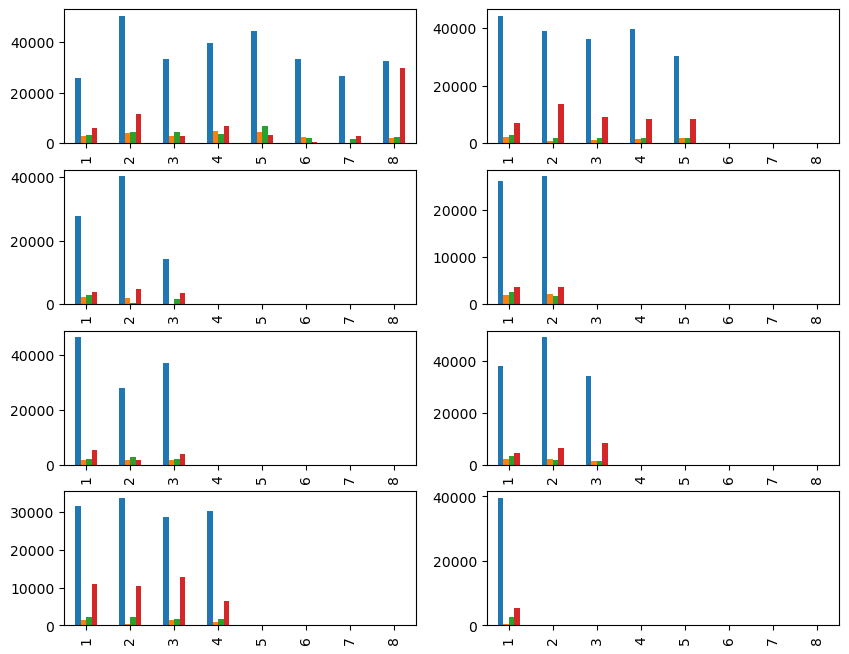

In [6]:
fig, ax = plt.subplots(figsize = (10, 8), nrows = 4, ncols = 2)
for ik, k in enumerate(dctClass.keys()):
    axs = ax.flatten()[ik]
    dctClass[k].plot.bar(ax = axs, legend = False)

In [7]:
def balanceData(dct, threshold = 2):

    dctBal = {f'subject_{k+1}':pd.DataFrame(index = range(1, 9), columns = range(0, 4), data = 0) for k in range(8)}

    for k in dctBal.keys():

        for i in dct[k].index:
            aux = dct[k].loc[i, :]
            aux2 = aux.sort_values(ascending = False)
            aux2.iloc[0] = aux2.iloc[1]

            if aux2.iloc[1] > threshold * aux2.iloc[2]:
                aux2.iloc[0] = threshold * aux2.iloc[2]
                aux2.iloc[1] = threshold * aux2.iloc[2]

            dctBal[k].loc[i, aux2.index] = aux2.values
    return dctBal

In [8]:
## get the number of instances for each to make the dataset balanced
## the first and second more frequents per session and individual are set to two times
## the third class in case they are larger. The mode is set as the same of the second 
## more repeated class
dctClassBal = balanceData(dctClass, 1.5)

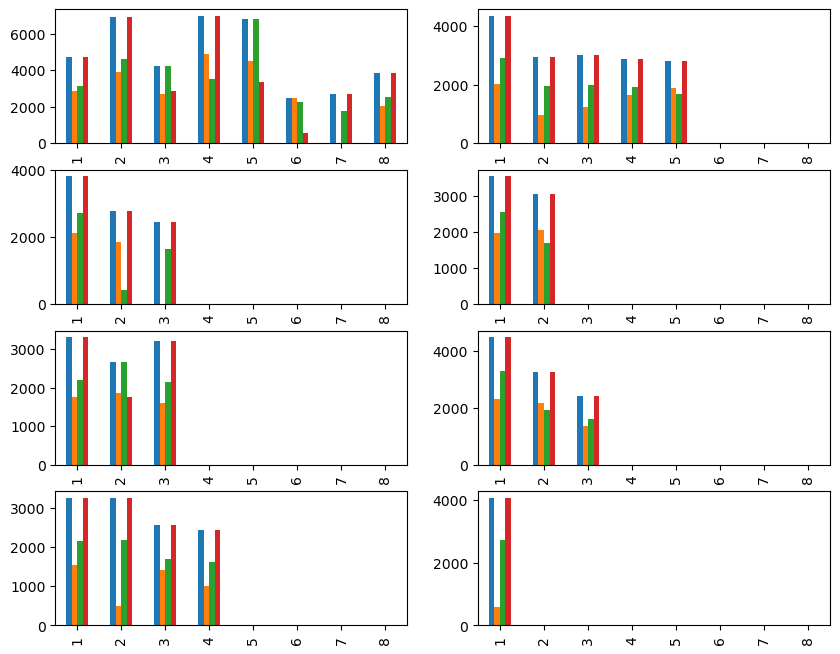

In [9]:
fig, ax = plt.subplots(figsize = (10, 8), nrows = 4, ncols = 2)
for ik, k in enumerate(dctClassBal.keys()):
    axs = ax.flatten()[ik]
    dctClassBal[k].plot.bar(ax = axs, legend = False)

<ipython-input-230-3503679998fc>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (24, 6))


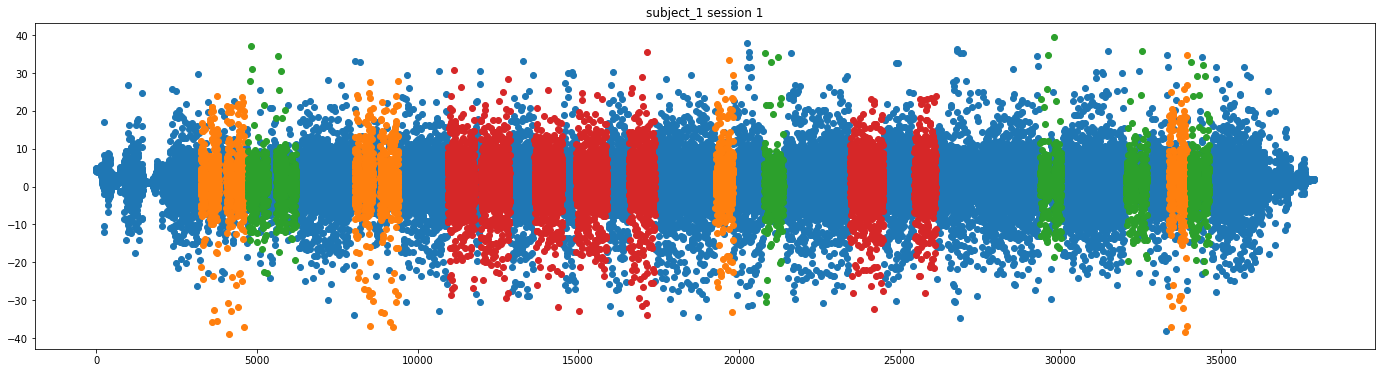

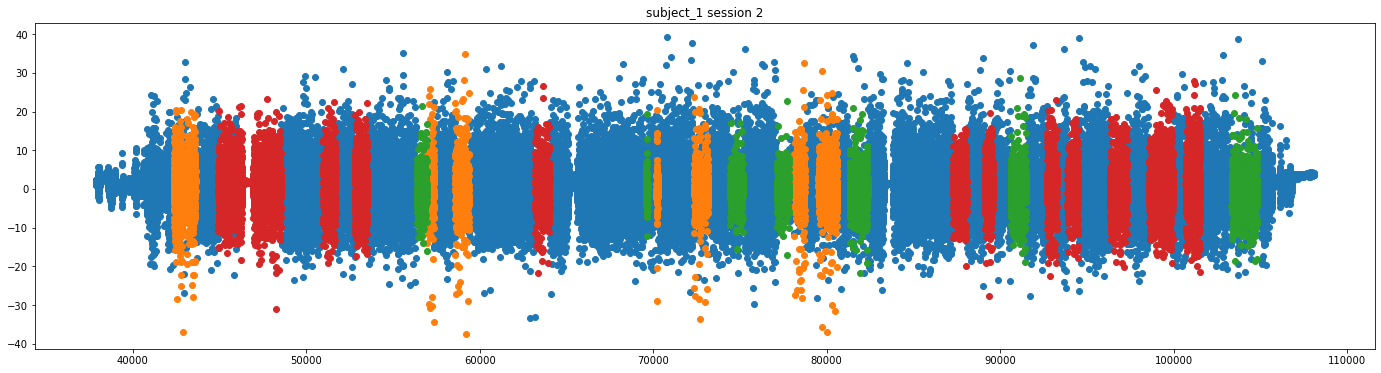

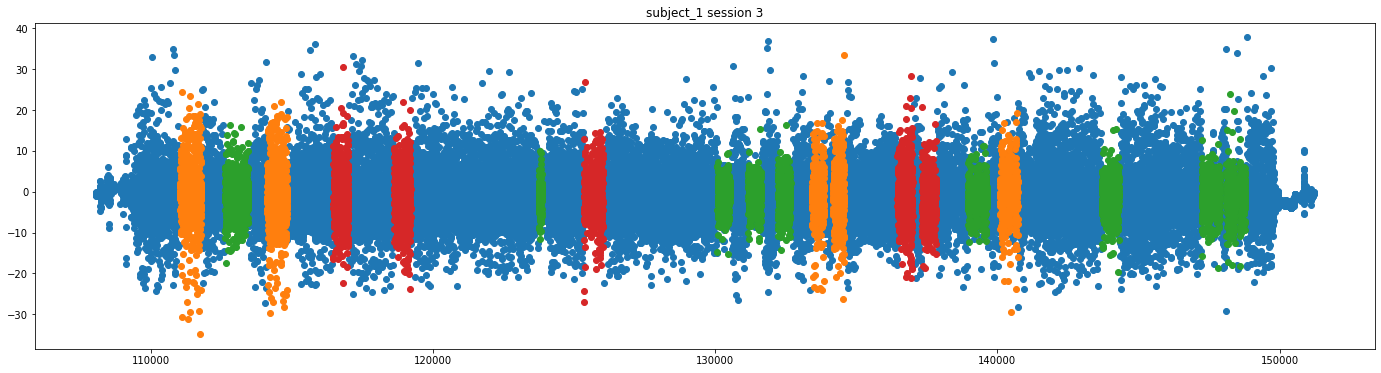

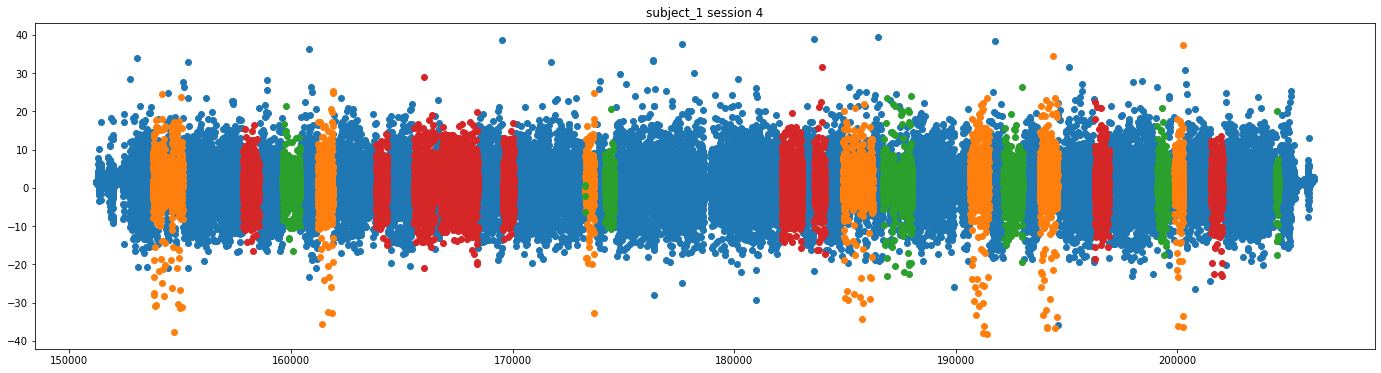

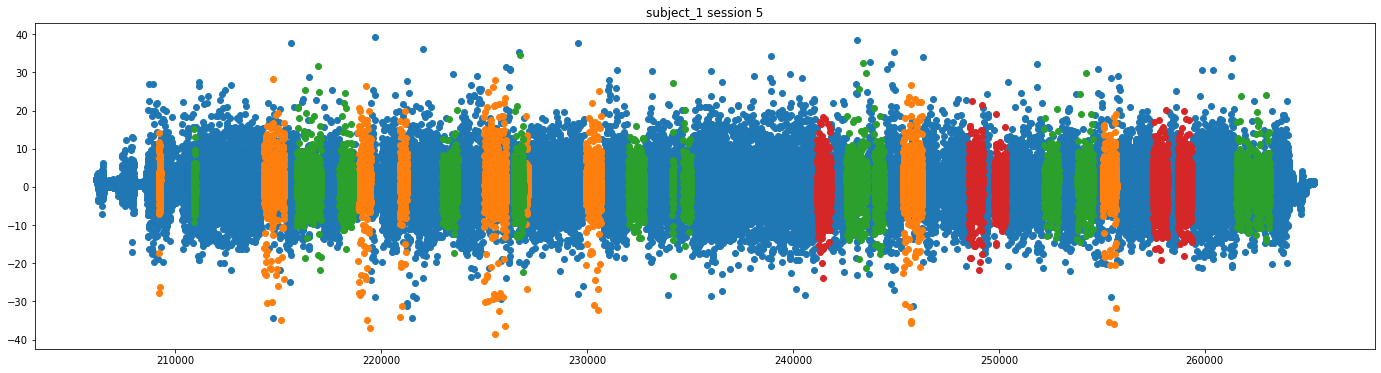

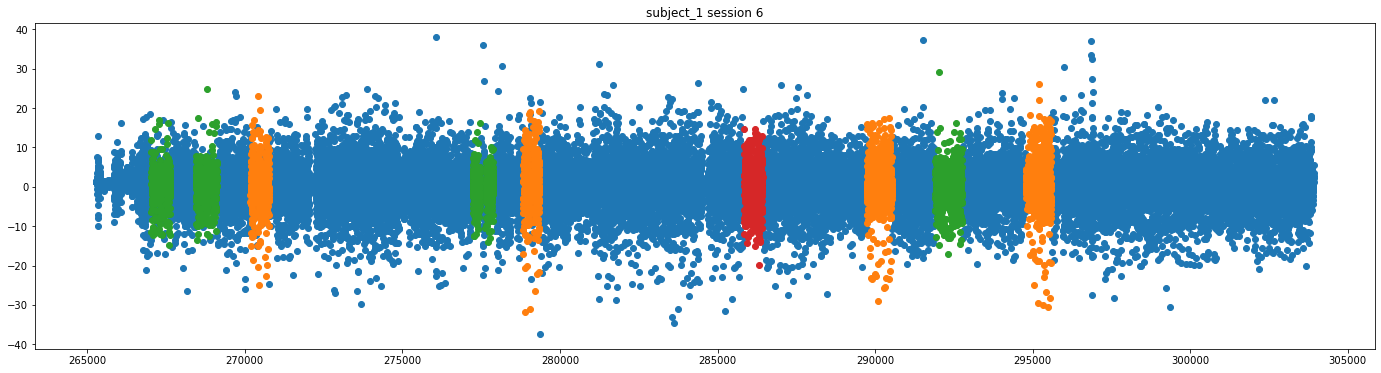

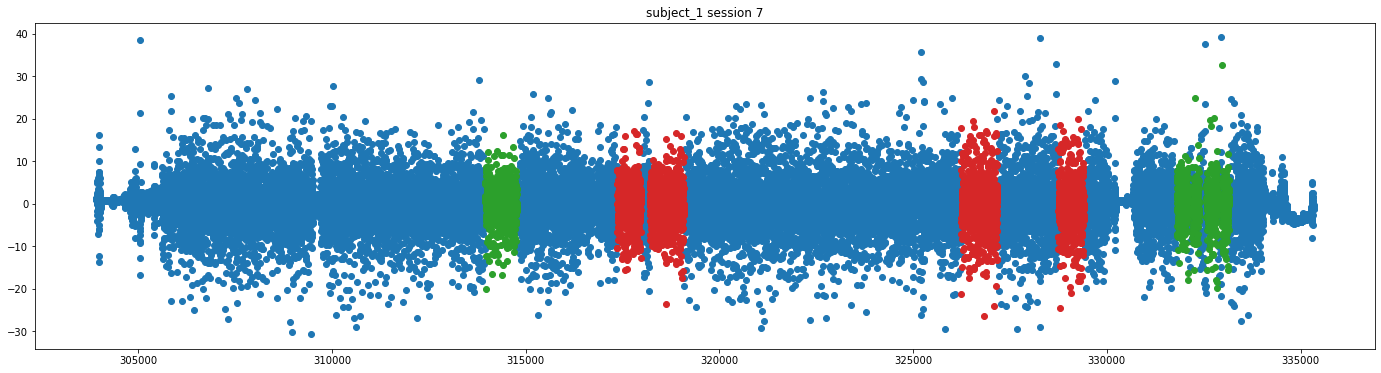

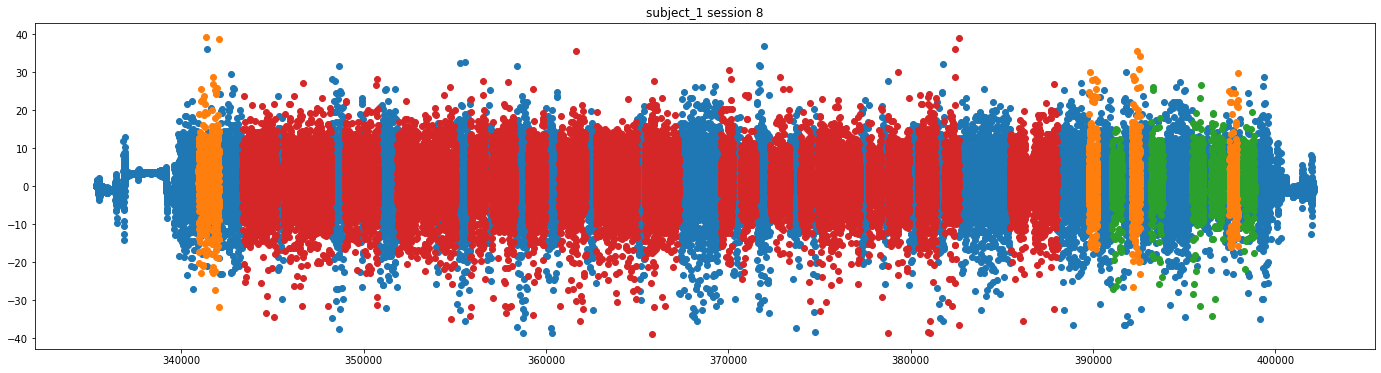

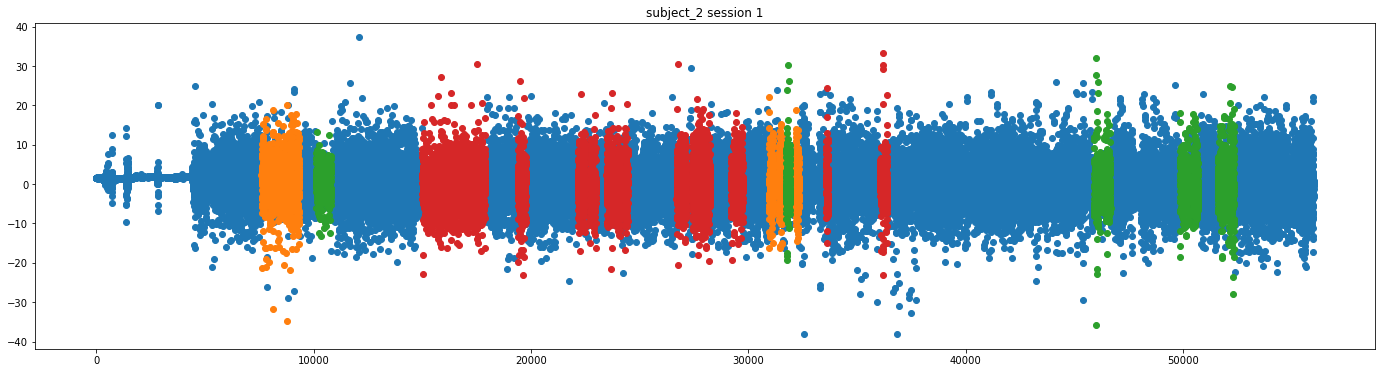

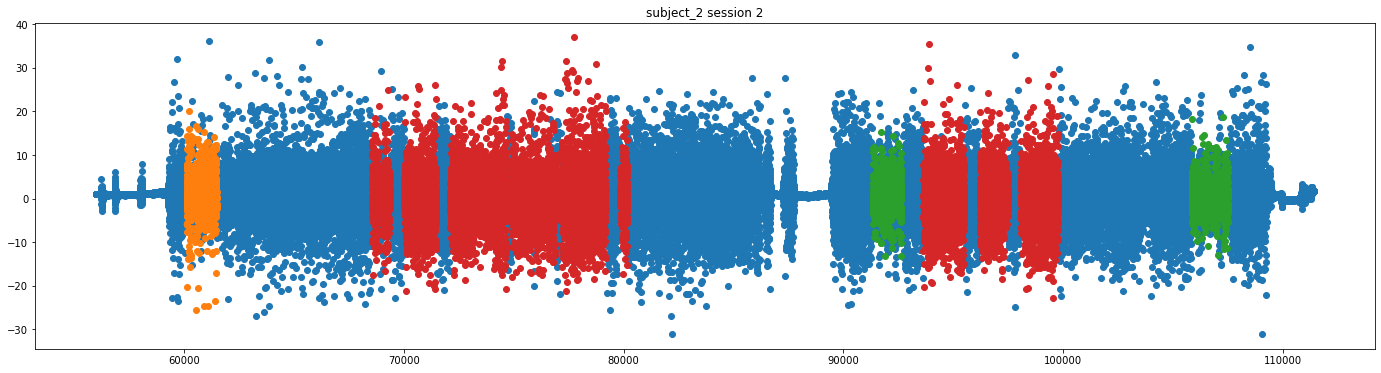

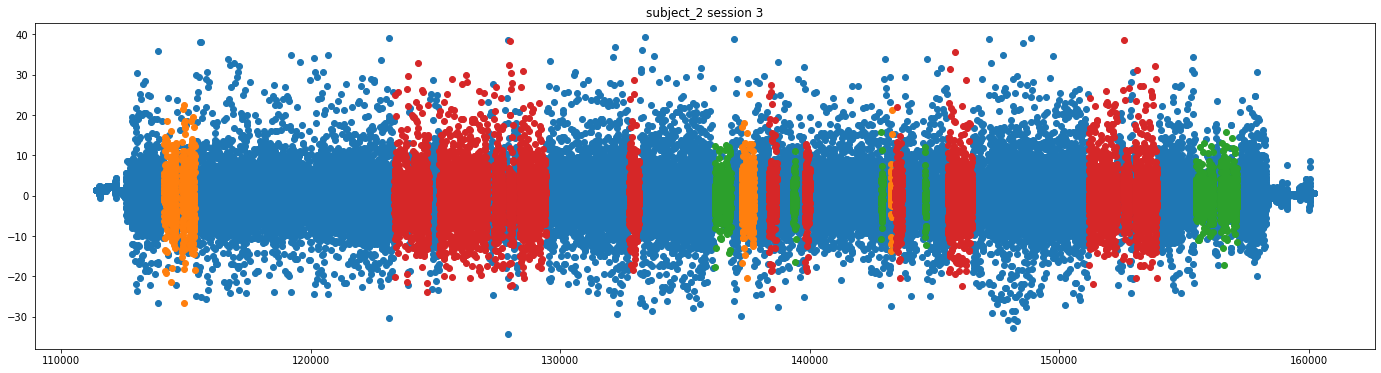

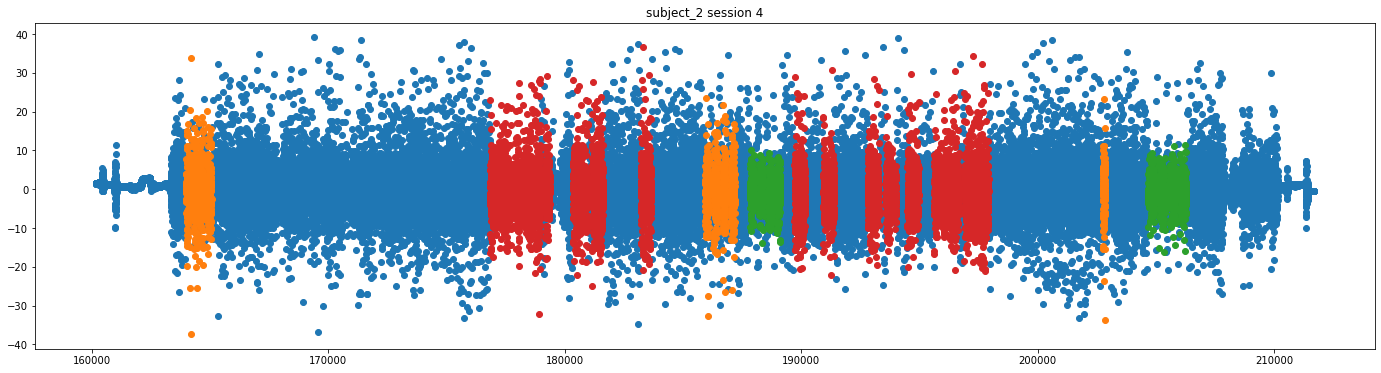

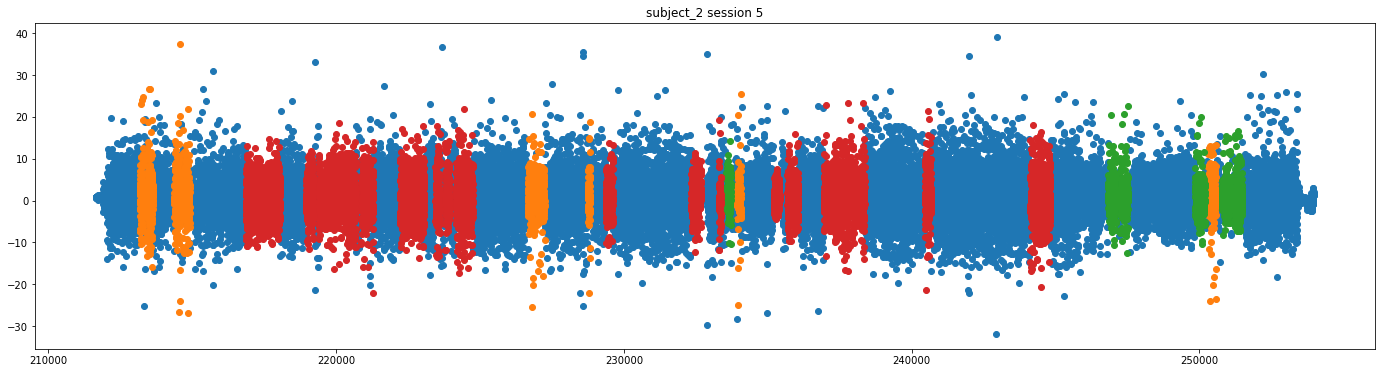

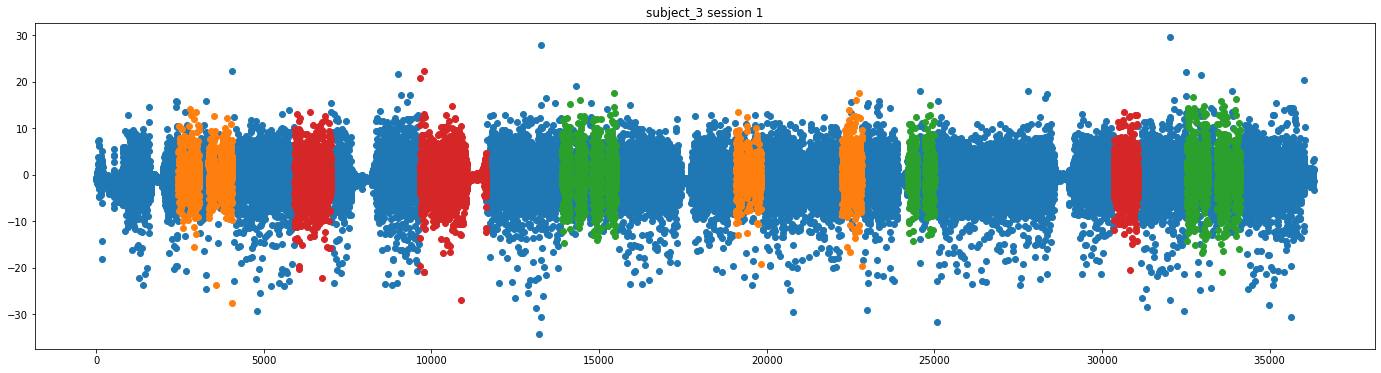

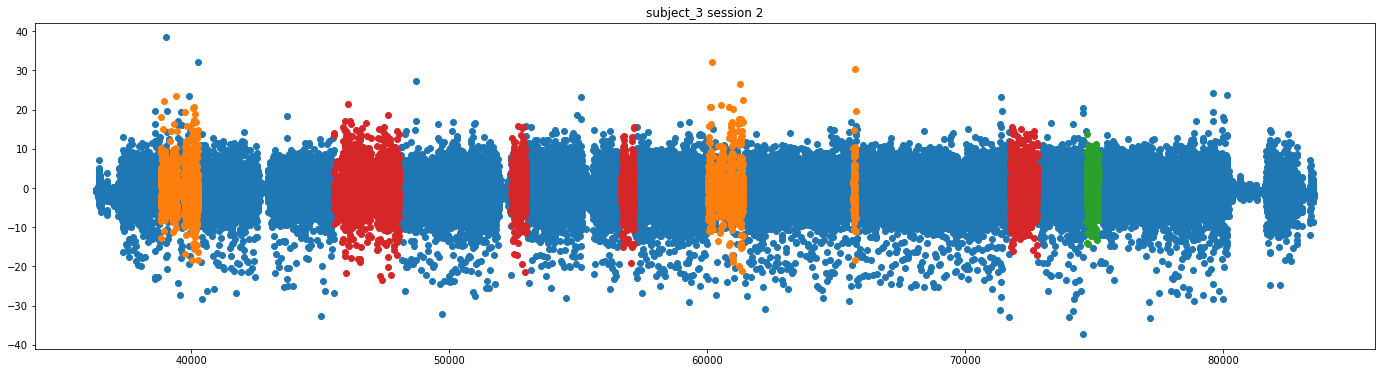

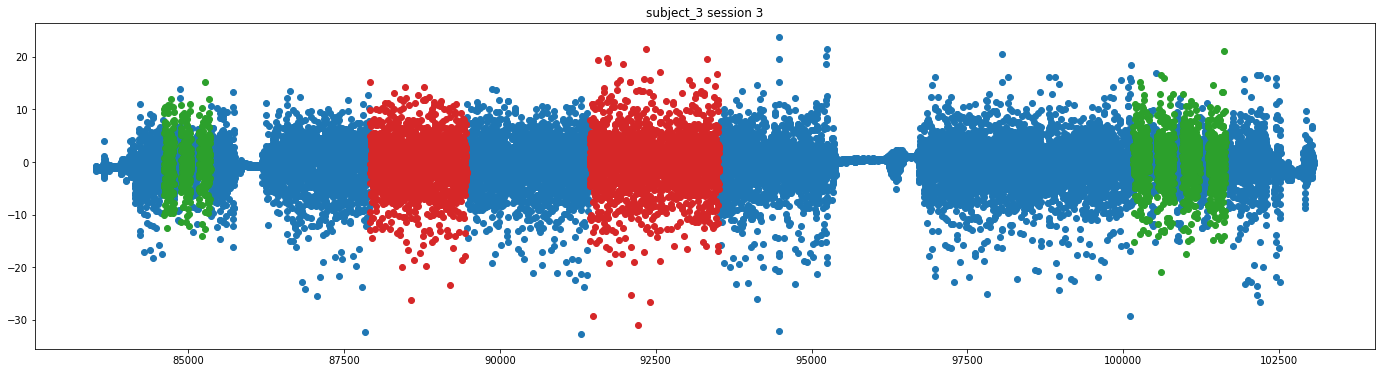

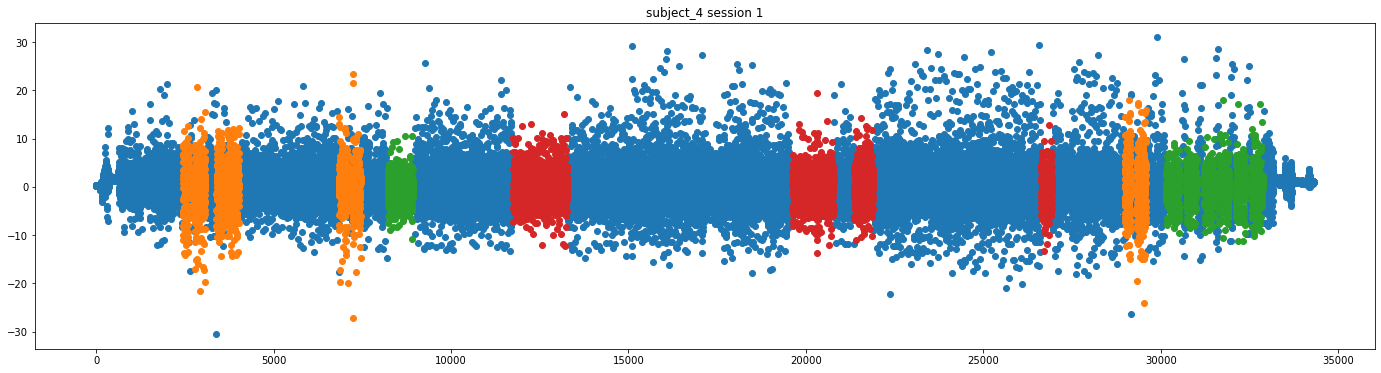

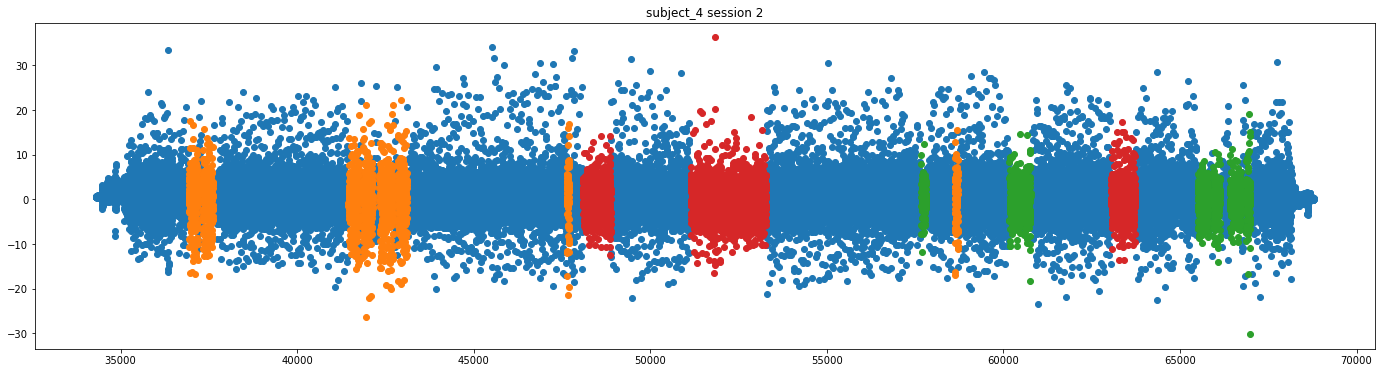

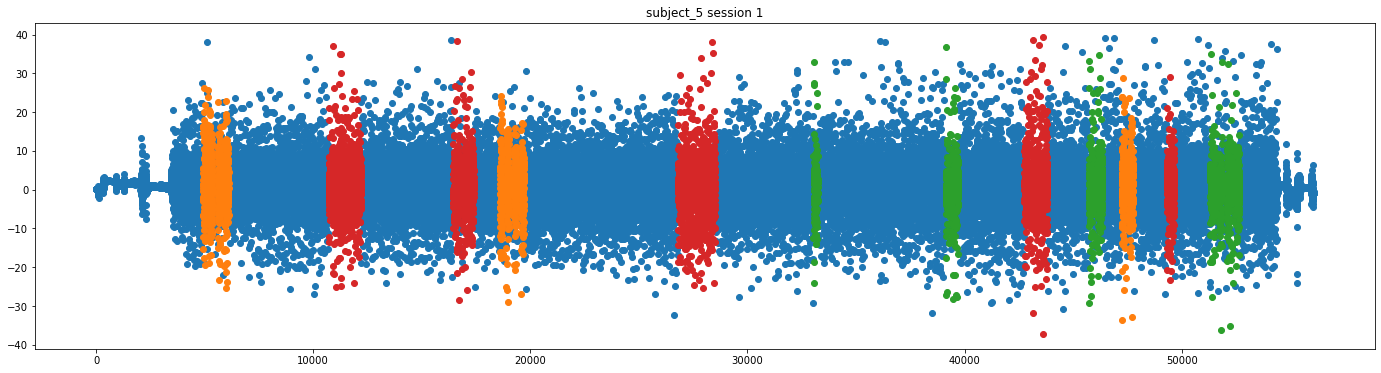

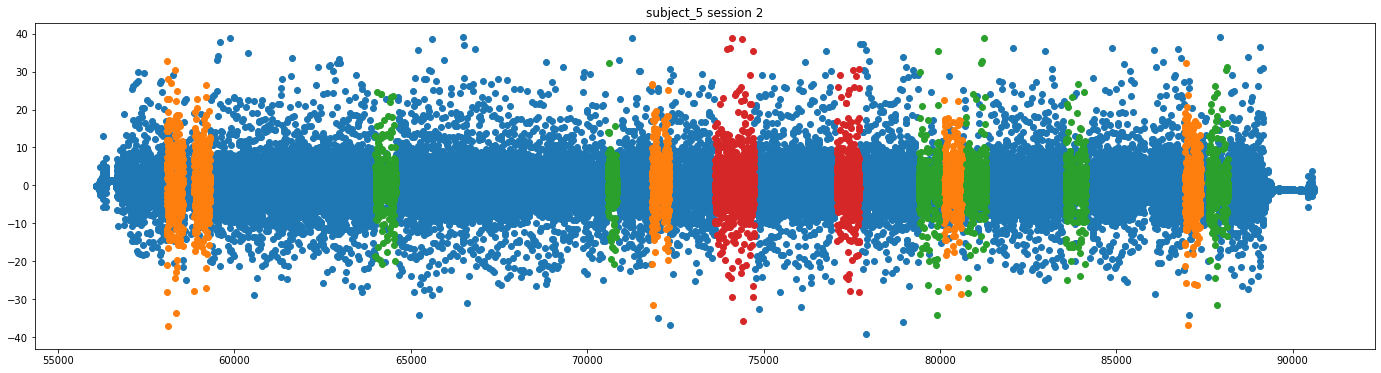

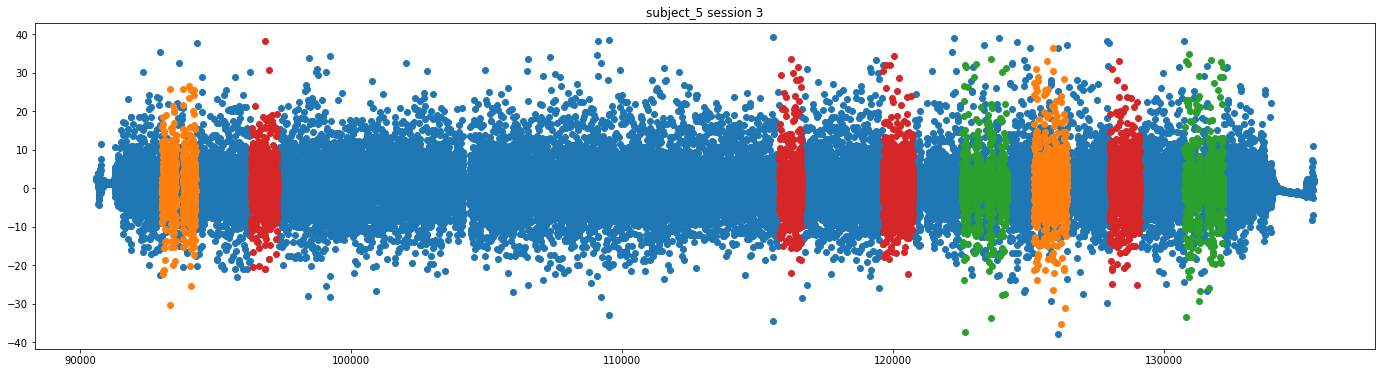

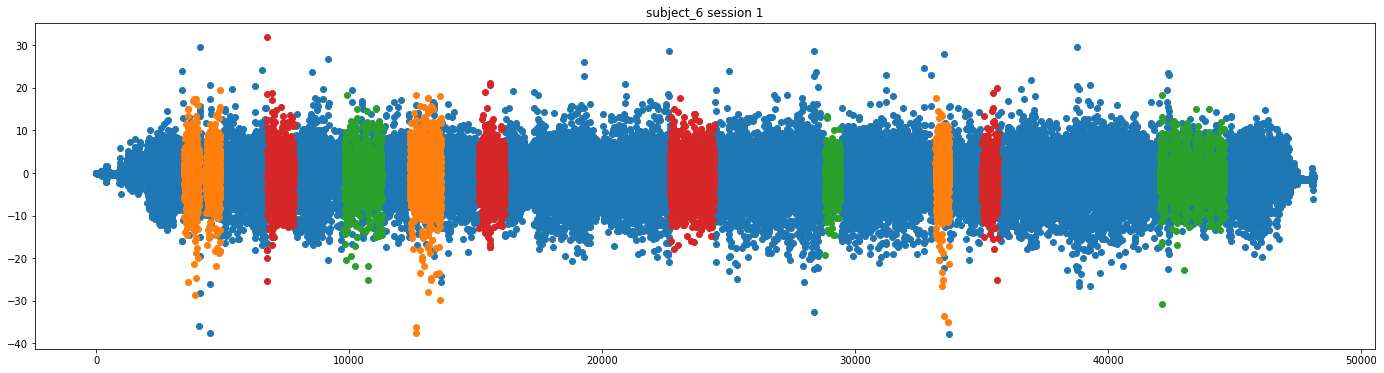

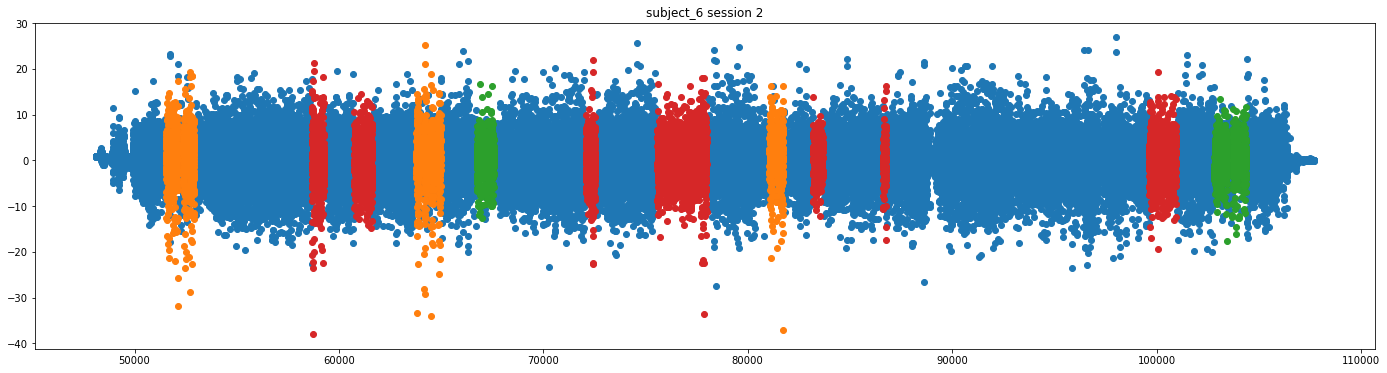

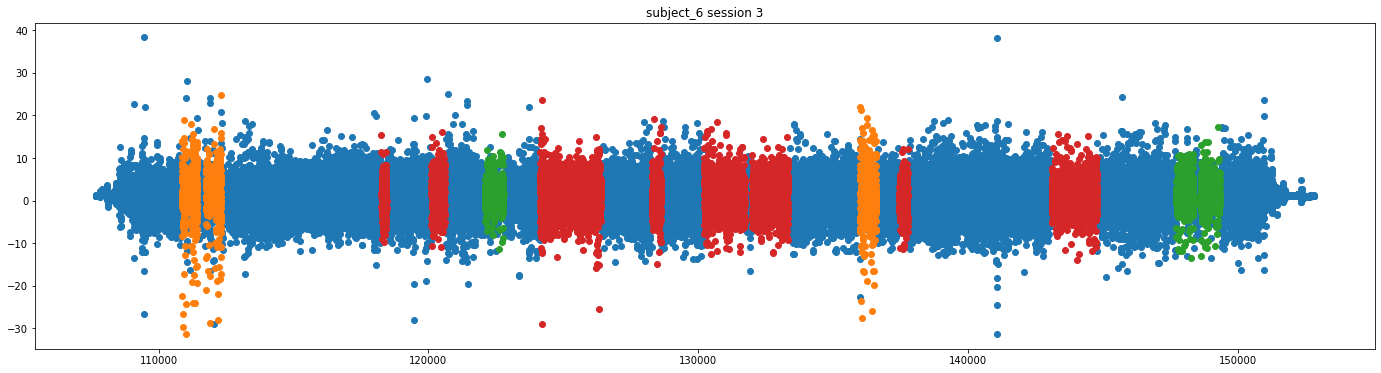

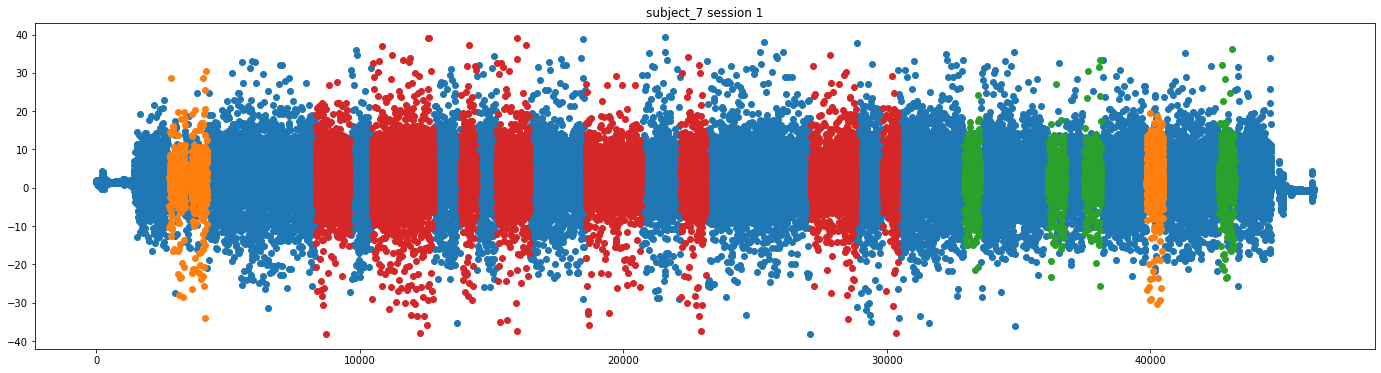

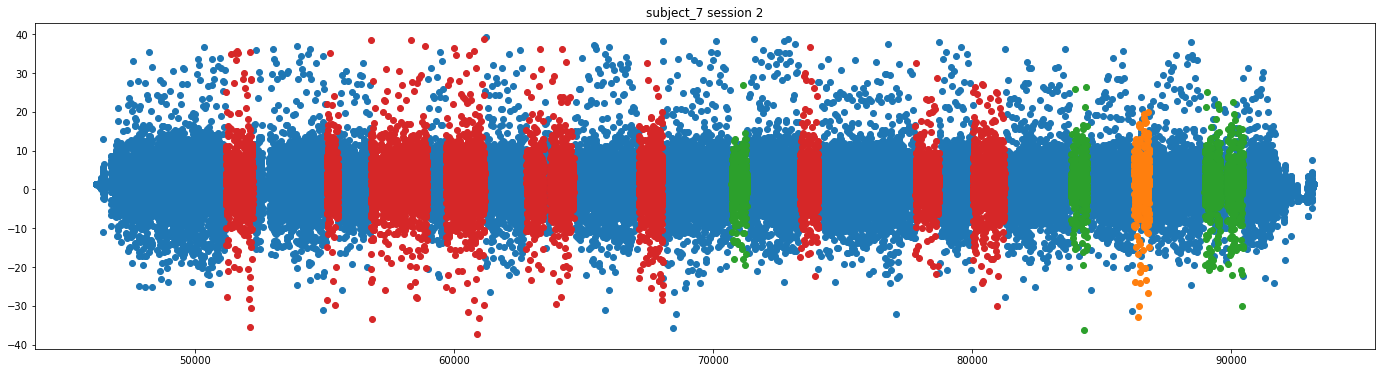

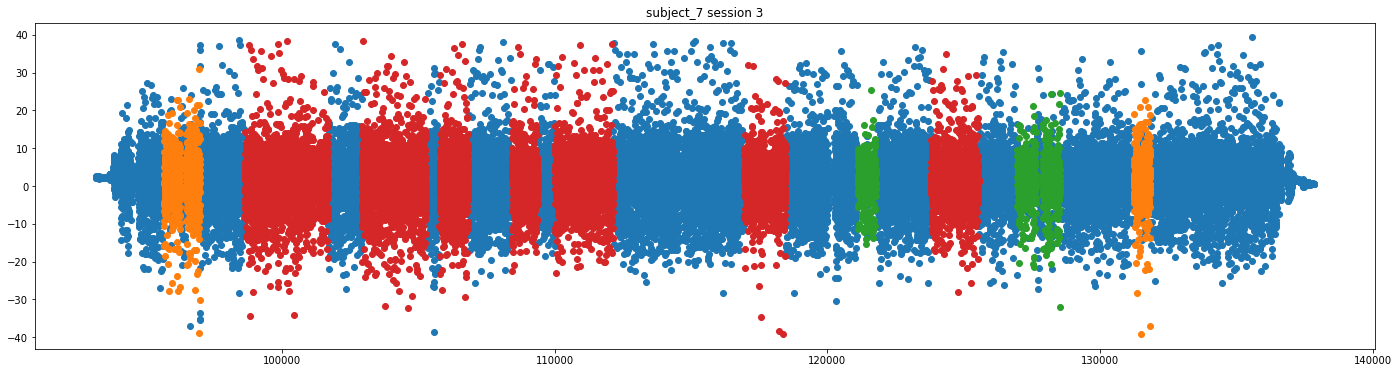

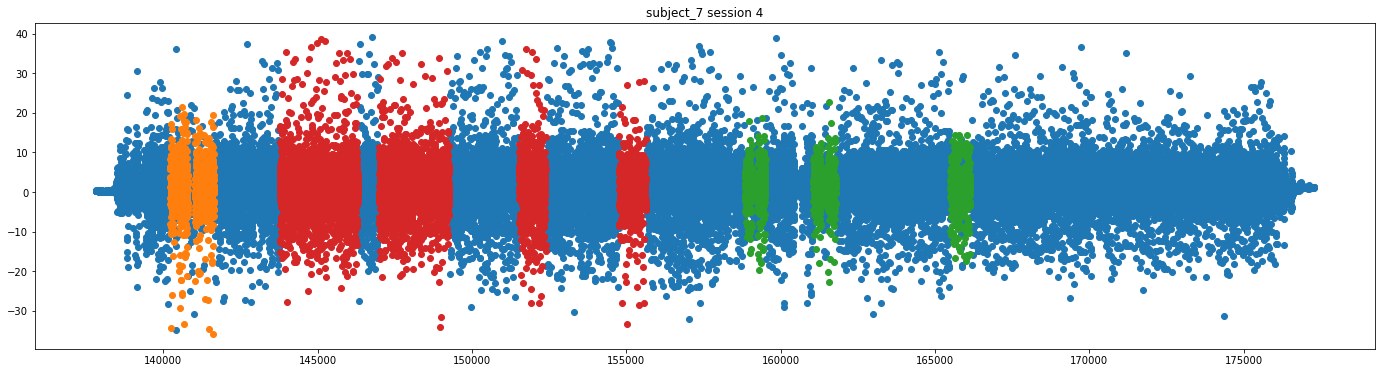

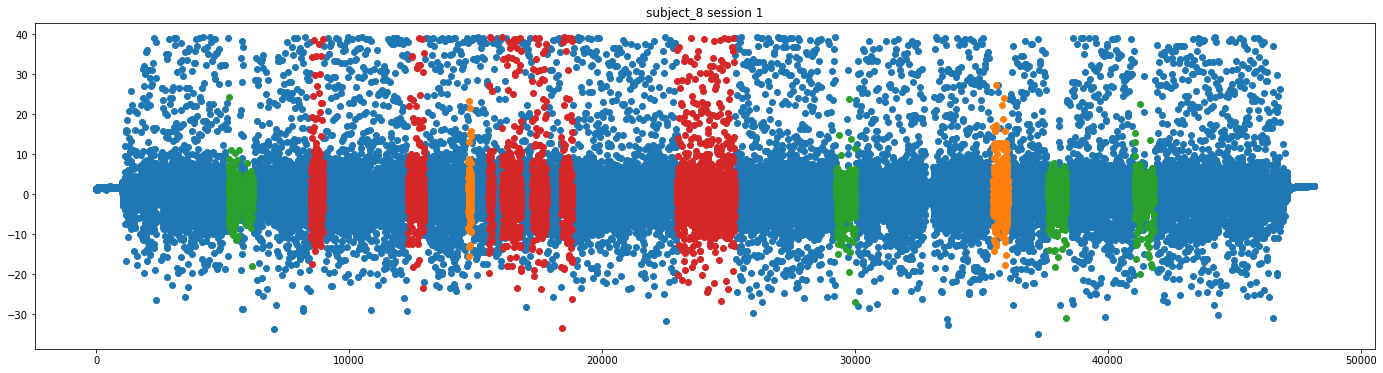

In [230]:
for k in dctUps.keys():
    for s in dctUps[k]['session'].unique():
        dfplot = dctUps[k][dctUps[k]['session'] == s]

        fig, ax = plt.subplots(figsize = (24, 6))
        for i in range(4):
            dfploti = dfplot[dfplot['class'] == i]
            ax.scatter(dfploti.index, dfploti['accx'])
            ax.set_title(k + f' session {s}')

In [21]:
## duplicate upsampled dictionary but with flags for the windows of each class in each session
## for each subject

windows_size = []

dctUpsWin = {}
for k in dctUps.keys():
    df = dctUps[k]
    dfout1 = []
    ## loop through sessions
    for s in df['session'].unique():
        dfs = df[df['session'] == s]
        ## shift to get indices of timesteps where class change occurs
        changeClass = dfs['class'] - dfs['class'].shift(1)
        changeClass = changeClass[changeClass != 0]
        dfs['window'] = [np.nan]*len(dfs)
        ## add flag to initial timestep of each window
        dfs.loc[changeClass.index, 'window'] = [f'class{c}_wind{x:03d}_ts00000' for x, c in enumerate(dfs.loc[changeClass.index, 'class'])]
        
        #iterate through windows to fill timesteps
        for i, j in zip(changeClass.index[:-1], changeClass.index[1:]):
            dummy = dfs.loc[i:j-1,:]
            wind = dummy.iloc[0, -1].split('_ts')[0]
            dummy.iloc[1:, -1] = [f'{wind}_ts{j+1:05d}' for j in range(len(dummy)-1)]
            windows_size.append(len(dummy))
        
        ## last window was not included in the for loop
        wind = dfs.loc[j, 'window'].split('_ts')[0]
        dfs.loc[j+1:, 'window'] = [f'{wind}_ts{j+1:05d}' for j in range(len(dfs.loc[j+1:, 'window']))]
        windows_size.append(len(dfs.loc[j+1:, 'window']))
        dfout1.append(dfs)
    dctUpsWin[k] = pd.concat(dfout1)

In [38]:
## randomly select values for the 2 mode classes to match the dctClassBal
dctUpsBal = {}
for k in dctUpsWin.keys():
    dfk =  dctUpsWin[k]
    out2 = []
    for s in dfk['session'].unique():
        dfks = dfk[dfk['session'] == s]

        nvalAll = dctClass[k].loc[s, :]
        nvalBall = dctClassBal[k].loc[s, :]
        
        out = []
        for c in nvalAll.index:
            dfksc = dfks[dfks['class'] == c]
            dfkscBal = dfks.sample(nvalBall.loc[c]).sort_index()
            out.append(dfkscBal)
        dfout = pd.concat(out).sort_index()
        out2.append(dfout)
    dctUpsBal[k] = pd.concat(out2)

In [203]:
dctSt = {}
for k in dctUpsBal.keys():
    dctUpsBal[k]['window_aux'] = [x.split('_ts')[0] for x in dctUpsBal[k]['window']]
    dfk = dctUpsBal[k].copy()
    list2 = []
    for s in dfk['session'].unique():
        dfks = dfk[dfk['session'] == s]
        for w in dfks['window_aux'].unique():
            dfksw = dfks[dfks['window_aux'] == w]
            list1 = []
            for ic, c in enumerate(dfksw.columns[:6]):
                dummy = list(dfksw[c].quantile(np.arange(0, 1.1, 0.1)))
                list1.extend(dummy)
            list1.append(int(dfksw['class'].unique()))
            list2.append(list1)
    dctSt[k] = pd.DataFrame(data = list2)

In [104]:
dfsum_bal = []
for key in dctClassBal.keys():
    dfsum_bal.append(dctClassBal[key].sum())

dfsum_bal = pd.DataFrame(index = dctClassBal.keys(), columns = dctClassBal['subject_1'].columns, data = dfsum_bal)
weights_bal = (dfsum_bal.sum()/dfsum_bal.sum().sum()).values
print(weights_bal)

[0.31823021 0.16698724 0.21978467 0.29499788]


## Model 03

#### Simple MLP

In [105]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(in_features = 66, out_features = 66*2)
    self.bn1 = nn.BatchNorm1d(num_features = 66*2)
    self.fc2 = nn.Linear(in_features = 66*2, out_features = 66)
    self.bn2 = nn.BatchNorm1d(num_features = 66)
    self.fc3 = nn.Linear(in_features = 66, out_features = 32)
    self.bn3 = nn.BatchNorm1d(num_features = 32)
    self.fc4 = nn.Linear(in_features = 32, out_features = 4)
    self.dout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.bn1(x)
    x = self.dout(x)

    x = self.fc2(x)
    x = F.relu(x)
    x = self.bn2(x)
    x = self.dout(x)

    x = self.fc3(x)
    x = F.relu(x)
    x = self.bn3(x)
    x = self.dout(x)
    
    x = self.fc4(x)
    x = F.softmax(x, dim = 1)

    return x

In [157]:
# Creating a wrapper so we have the same interface for all the methods
class NetWrapper:
  def __init__(self, epochs, lrate, dev, w):
    self.model = Net()
    if w != None:
      self.loss = nn.CrossEntropyLoss(w)
    else:
      self.loss = nn.CrossEntropyLoss()
      
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lrate)
    self.device = dev
    self.model.to(self.device)
    self.epochs = epochs
    self.history = {'train_loss': [], 'test_loss': []}
    self.min_loss = np.inf
    self.best_weights = None

  def fit(self, X_train, Y_train, X_test, Y_test):
    
    # train_dataset = CustomDataset(X_train, Y_train, self.device, seq_length=self.seq_length)
    # train_dataloader = DataLoader(train_dataset, batch_size = batchsize, shuffle = False)
    # test_dataset = CustomDataset(X_test, Y_test, self.device, seq_length=self.seq_length)
    # test_dataloader = DataLoader(test_dataset, batch_size = batchsize, shuffle = False)
    
    for t in range(self.epochs):

        ########### Training
        self.model.train()
        self.optimizer.zero_grad()
        X_train2 = torch.from_numpy(X_train).to(torch.float32).to(device)
        Y_pred = self.model(X_train2)#.argmax(axis = 2)
        # Y_train_b = torch.squeeze(Y_train_b, 1)
        ## compute loss
        Y_train2 = torch.from_numpy(Y_train).to(device)
        loss = self.loss(Y_pred, Y_train2)
        loss_val = float(loss.cpu().detach().numpy())
        ## backward propagation
        loss.backward()
        self.optimizer.step()
        self.history[r'train_loss'].append(loss_val)

        ########### Evaluation
        self.model.eval()
        X_test2 = torch.from_numpy(X_test).to(torch.float32).to(device)
        Y_pred = self.model(X_test2)
        ## compute loss
        Y_test2 = torch.from_numpy(Y_test).to(device)
        loss = self.loss(Y_pred, Y_test2)
        loss_val = float(loss.cpu().detach().numpy())
        self.history[r'test_loss'].append(loss_val)

        if loss < self.min_loss:
          self.min_loss = loss
          self.best_weights = copy.deepcopy(self.model.state_dict())

        if t%1000 == 0:
          a = self.history[f'train_loss'][t]
          b = self.history[f'test_loss'][t]
        
          print(f'Epoch {t}/{self.epochs}. Training loss: {a:0.3f} - Validation loss: {b:0.3f}')
    
    dfhist = pd.DataFrame.from_dict(self.history)

    return dfhist, self.min_loss, self.best_weights

  def predict(self, X):
    X = torch.from_numpy(X).float().to(self.device)

    pred = self.model(X)
    pred = pred.cpu().detach().numpy()

    return pred

*************************   Validation with subject 6   *************************

Epoch 0/10000. Training loss: 1.390 - Validation loss: 1.390
Epoch 10/10000. Training loss: 1.356 - Validation loss: 1.393
Epoch 20/10000. Training loss: 1.327 - Validation loss: 1.378
Epoch 30/10000. Training loss: 1.295 - Validation loss: 1.345
Epoch 40/10000. Training loss: 1.275 - Validation loss: 1.311
Epoch 50/10000. Training loss: 1.243 - Validation loss: 1.283
Epoch 60/10000. Training loss: 1.224 - Validation loss: 1.261
Epoch 70/10000. Training loss: 1.200 - Validation loss: 1.242
Epoch 80/10000. Training loss: 1.177 - Validation loss: 1.225
Epoch 90/10000. Training loss: 1.159 - Validation loss: 1.209
Epoch 100/10000. Training loss: 1.140 - Validation loss: 1.193
Epoch 110/10000. Training loss: 1.130 - Validation loss: 1.179
Epoch 120/10000. Training loss: 1.110 - Validation loss: 1.164
Epoch 130/10000. Training loss: 1.097 - Validation loss: 1.151
Epoch 140/10000. Training loss: 1.088 - Valida

Text(0.5, 1.0, 'F1 score: 0.838')

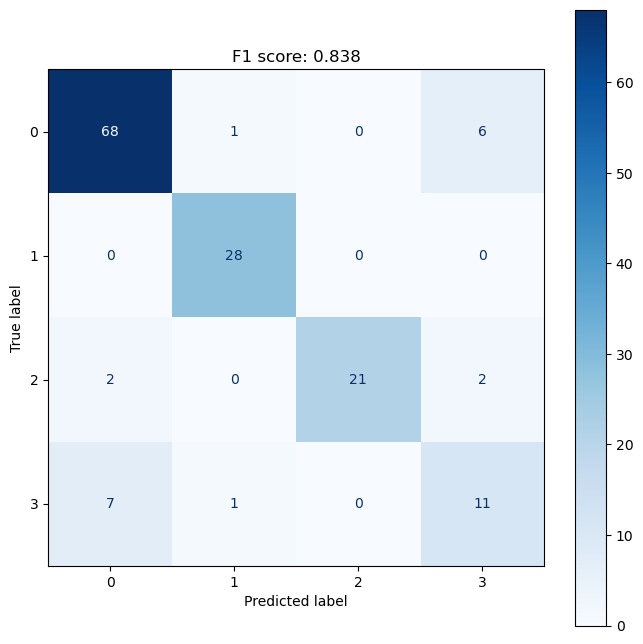

In [184]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

hists = []
lossAll = []
models = []

# for i in range(8):
i = 6
keyval = f'subject_{i}'
df_val = dctSt[keyval]

df_tr = []
for k in dctSt.keys():
  if k != keyval:
    df_tr.append(dctSt[k])
df_tr = pd.concat(df_tr)

Xtr = df_tr.iloc[:, :-1]
ytr = df_tr.iloc[:, -1]

Xvl = df_val.iloc[:, :-1] 
yvl = df_val.iloc[:, -1]

scaler = StandardScaler()
Xtr_sc = scaler.fit_transform(Xtr.values)
Xvl_sc = scaler.transform(Xvl.values)

print(f'*************************   Validation with subject {i}   *************************\n')
net = NetWrapper(10_000, learning_rate, device, None)
dfhist, minLoss, bestModel = net.fit(Xtr_sc, ytr.values, Xvl_sc, yvl.values)

pred = net.predict(Xvl_sc).argmax(axis = 1)
m = confusion_matrix(yvl.values, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=m)
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax,  cmap = plt.cm.Blues)
ax.set_title(f"F1 score: {f1_score(pred, yvl.values, average='macro'):0.3f}")

#### More neurones and layers

In [208]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(in_features = 66, out_features = 66*4)
    self.bn1 = nn.BatchNorm1d(num_features = 66*4)
    self.fc2 = nn.Linear(in_features = 66*4, out_features = 66*8)
    self.bn2 = nn.BatchNorm1d(num_features = 66*8)
    self.fc3 = nn.Linear(in_features = 66*8, out_features = 66*4)
    self.bn3 = nn.BatchNorm1d(num_features = 66*4)
    self.fc4 = nn.Linear(in_features = 66*4, out_features = 66*2)
    self.bn4 = nn.BatchNorm1d(num_features = 66*2)
    self.fc5 = nn.Linear(in_features = 66*2, out_features = 66)
    self.bn5 = nn.BatchNorm1d(num_features = 66)
    self.fc6 = nn.Linear(in_features = 66, out_features = 32)
    self.bn6 = nn.BatchNorm1d(num_features = 32)
    self.fc7 = nn.Linear(in_features = 32, out_features = 4)
    self.dout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.bn1(x)
    x = self.dout(x)

    x = self.fc2(x)
    x = F.relu(x)
    x = self.bn2(x)
    x = self.dout(x)

    x = self.fc3(x)
    x = F.relu(x)
    x = self.bn3(x)
    x = self.dout(x)

    x = self.fc4(x)
    x = F.relu(x)
    x = self.bn4(x)
    x = self.dout(x)

    x = self.fc5(x)
    x = F.relu(x)
    x = self.bn5(x)
    x = self.dout(x)

    x = self.fc6(x)
    x = F.relu(x)
    x = self.bn6(x)
    x = self.dout(x)
    
    x = self.fc7(x)
    x = F.softmax(x, dim = 1)

    return x

In [209]:
# Creating a wrapper so we have the same interface for all the methods
class NetWrapper:
  def __init__(self, epochs, lrate, dev, w):
    self.model = Net()
    if w != None:
      self.loss = nn.CrossEntropyLoss(w)
    else:
      self.loss = nn.CrossEntropyLoss()
      
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lrate)
    self.device = dev
    self.model.to(self.device)
    self.epochs = epochs
    self.history = {'train_loss': [], 'test_loss': []}
    self.min_loss = np.inf
    self.best_weights = None

  def fit(self, X_train, Y_train, X_test, Y_test):
    
    for t in range(self.epochs):

        ########### Training
        self.model.train()
        self.optimizer.zero_grad()
        X_train2 = torch.from_numpy(X_train).to(torch.float32).to(device)
        Y_pred = self.model(X_train2)#.argmax(axis = 2)
        # Y_train_b = torch.squeeze(Y_train_b, 1)
        ## compute loss
        Y_train2 = torch.from_numpy(Y_train).to(device)
        loss = self.loss(Y_pred, Y_train2)
        loss_val = float(loss.cpu().detach().numpy())
        ## backward propagation
        loss.backward()
        self.optimizer.step()
        self.history[r'train_loss'].append(loss_val)

        ########### Evaluation
        self.model.eval()
        X_test2 = torch.from_numpy(X_test).to(torch.float32).to(device)
        Y_pred = self.model(X_test2)
        ## compute loss
        Y_test2 = torch.from_numpy(Y_test).to(device)
        loss = self.loss(Y_pred, Y_test2)
        loss_val = float(loss.cpu().detach().numpy())
        self.history[r'test_loss'].append(loss_val)

        if loss < self.min_loss:
          self.min_loss = loss
          self.best_weights = copy.deepcopy(self.model.state_dict())

        if t%1000 == 0:
          a = self.history[f'train_loss'][t]
          b = self.history[f'test_loss'][t]
        
          print(f'Epoch {t}/{self.epochs}. Training loss: {a:0.3f} - Validation loss: {b:0.3f}')
    
    dfhist = pd.DataFrame.from_dict(self.history)

    return dfhist, self.min_loss, self.best_weights

  def predict(self, X):
    X = torch.from_numpy(X).float().to(self.device)

    pred = self.model(X)
    pred = pred.cpu().detach().numpy()

    return pred

*************************   Validation with subject 6   *************************

Epoch 0/10000. Training loss: 2.997 - Validation loss: 2.995
Epoch 1000/10000. Training loss: 2.095 - Validation loss: 2.229
Epoch 2000/10000. Training loss: 2.084 - Validation loss: 2.221
Epoch 3000/10000. Training loss: 2.081 - Validation loss: 2.223
Epoch 4000/10000. Training loss: 2.080 - Validation loss: 2.258
Epoch 5000/10000. Training loss: 2.080 - Validation loss: 2.217
Epoch 6000/10000. Training loss: 2.080 - Validation loss: 2.230
Epoch 7000/10000. Training loss: 2.080 - Validation loss: 2.228
Epoch 8000/10000. Training loss: 2.080 - Validation loss: 2.243
Epoch 9000/10000. Training loss: 2.080 - Validation loss: 2.214


Text(0.5, 1.0, 'F1 score: 0.854')

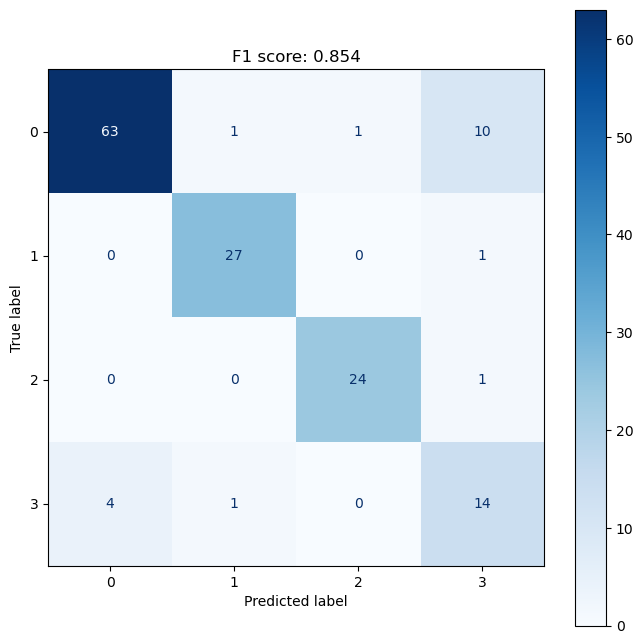

In [210]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

# for i in range(8):
i = 6
keyval = f'subject_{i}'
df_val = dctSt[keyval]

df_tr = []
for k in dctSt.keys():
  if k != keyval:
    df_tr.append(dctSt[k])
df_tr = pd.concat(df_tr)

Xtr = df_tr.iloc[:, :-1]
ytr = df_tr.iloc[:, -1]

Xvl = df_val.iloc[:, :-1] 
yvl = df_val.iloc[:, -1]

scaler = StandardScaler()
Xtr_sc = scaler.fit_transform(Xtr.values)
Xvl_sc = scaler.transform(Xvl.values)

print(f'*************************   Validation with subject {i}   *************************\n')
net = NetWrapper(10_000, learning_rate, device, None)
dfhist, minLoss, bestModel = net.fit(Xtr_sc, ytr.values, Xvl_sc, yvl.values)

pred = net.predict(Xvl_sc).argmax(axis = 1)
m = confusion_matrix(yvl.values, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=m)
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax,  cmap = plt.cm.Blues)
ax.set_title(f"F1 score: {f1_score(pred, yvl.values, average='macro'):0.3f}")